In [2]:
"""
error log
ValueError: Error when checking target: expected conv2d_22 to have shape (61, 61, 3) but got array with shape (64, 64, 3)
output of layer is the first and the target is 64*64*3, need to match output
"""

'\nerror log\nValueError: Error when checking target: expected conv2d_22 to have shape (61, 61, 3) but got array with shape (64, 64, 3)\noutput of layer is the first and the target is 64*64*3, need to match output\n'

In [3]:
import os
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from os import listdir

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11328043599118510142
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16473106375393879477
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [5]:
import sys
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/FA2018/tutorials/ferienakademie2018-accelerating-physics-with-deep-learning/')
from functions import *

In [6]:
#forces CPU usage
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [7]:
os.getcwd()

'C:\\Users\\pkicsiny\\Desktop\\FA2018\\tutorials\\ferienakademie2018-accelerating-physics-with-deep-learning'

In [8]:
dataDir = os.getcwd() + '/data/trainSmallFA'
files = listdir(dataDir)
files[0:5]

['sm_goe503_1050_57.npz',
 'sm_goe503_1079_209.npz',
 'sm_goe503_1093_355.npz',
 'sm_goe503_1110_304.npz',
 'sm_goe503_1152_78.npz']

In [9]:
totalLength = len(files)

In [10]:
#array of inputs and outputs (predictions of the network)
inputs = np.empty((totalLength,3,64,64))
targets = np.empty_like(inputs)

In [11]:
np.shape(inputs) == np.shape(targets)

True

### Data prerpocessing

In [12]:
c = 1
for i, file in enumerate(files):
    npfile = np.load(dataDir +'/' + file)
    #a file contains 6 images: 3 for input p, vx, vy and output (ground truth) 
    d = npfile['a']
    inputs[i]  = d[0:3]   # inx, iny, mask 
    targets[i] = d[3:6]   # p, velx, vely
    if c:
        print('Shape of input-target array:',np.shape(targets))
        print('Shape of an element of input + output:',np.shape(d))
        # splits input file content of 6 channels to 3-3
        c = 0

Shape of input-target array: (751, 3, 64, 64)
Shape of an element of input + output: (6, 64, 64)


In [13]:
print('Input maxes:',inputs[:,0,:,:].max(), inputs[:,1,:,:].max(), inputs[:,2,:,:].max())
print('Input mins:',inputs[:,0,:,:].min(), inputs[:,1,:,:].min(), inputs[:,2,:,:].min())
print('Target maxes:',targets[:,0,:,:].max(), targets[:,1,:,:].max(), targets[:,2,:,:].max())
print('Target mins:',targets[:,0,:,:].min(), targets[:,1,:,:].min(), targets[:,2,:,:].min())

Input maxes: 98.70918772289284 36.22861719358889 1.0
Input mins: 0.0 0.0 0.0
Target maxes: 4321.8 171.772 140.251
Target mins: -13757.3 -71.886 -58.4272


In [14]:
normalized_inputs, normalized_targets = preprocess_data(inputs,targets,norm = 1)

In [15]:
print('Normalized input maxes:',normalized_inputs[:,0,:,:].max(), normalized_inputs[:,1,:,:].max(), normalized_inputs[:,2,:,:].max())
print('Normalized input mins:',normalized_inputs[:,0,:,:].min(), normalized_inputs[:,1,:,:].min(), normalized_inputs[:,2,:,:].min())
print('Normalized target maxes:',normalized_targets[:,0,:,:].max(), normalized_targets[:,1,:,:].max(), normalized_targets[:,2,:,:].max())
print('Normalized target mins:',normalized_targets[:,0,:,:].min(), normalized_targets[:,1,:,:].min(), normalized_targets[:,2,:,:].min())

Normalized input maxes: 1.0 1.0 1.0
Normalized input mins: -1.0 -1.0 -1.0
Normalized target maxes: 1.0 1.0 1.0
Normalized target mins: -1.0 -1.0 -1.0


### Split datasets

In [16]:
train_val_inputs,train_val_targets,test_inputs,test_targets = randsplit(normalized_inputs,normalized_targets,frac=.9)

In [17]:
#training data
train_val_inputs  = train_val_inputs.transpose(0,2,3,1)
train_val_targets = train_val_targets.transpose(0,2,3,1)

#test dataset
test_inputs  = test_inputs.transpose(0,2,3,1)
test_targets = test_targets.transpose(0,2,3,1)

print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(test_inputs),np.shape(test_targets))

Training data shape: (675, 64, 64, 3) (675, 64, 64, 3)
Test data shape: (76, 64, 64, 3) (76, 64, 64, 3)


In [18]:
#flattening if last layer is fcl
train_val_targets = np.reshape(train_val_targets,(len(train_val_targets),-1))
test_targets = np.reshape(test_targets,(len(test_targets),-1))

In [19]:
print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(test_inputs),np.shape(test_targets))

Training data shape: (675, 64, 64, 3) (675, 12288)
Test data shape: (76, 64, 64, 3) (76, 12288)


### Network architecture

In [20]:
#convolution filters
f1 = 8
f2 = 3
#kernel size
k1 = 4
k2 = 2
#stride
s1 = 4
s2 = 2
#padding
p1 = 0
p2 = 0

Toy network

In [21]:
model=keras.Sequential()

conv1 = keras.layers.Conv2D(input_shape = (64,64,3),
                              filters = f1,
                              kernel_size=(k1,k1),
                              strides=(s1, s1),
                              padding='valid',
                              data_format = "channels_last",
                             activation = 'tanh')
conv2 = keras.layers.Conv2D(input_shape = (16,16,3),
                              filters = f2,
                              kernel_size=(k2,k2),
                              strides=(s2, s2),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
conv3 = keras.layers.Conv2D(input_shape = (8,8,3),
                              filters = 3,
                              kernel_size=(8,8),
                              strides=(1, 1),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
upsample1 = keras.layers.UpSampling2D(size=(4, 4), data_format="channels_last",input_shape = (8,8,3))
dense1 = keras.layers.Dense(64*64*3,activation='tanh')
#architeccture
model.add(conv1)
model.add(conv2)
model.add(conv3)
model.add(upsample1)
model.add(keras.layers.Flatten())
model.add(dense1)

U-net

In [21]:
model2=keras.Sequential()

init = keras.layers.Input(shape=(64,64,3))
ConvDown1  = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(2,2),padding="same",activation='relu')(init)
ConvDown2  = keras.layers.Conv2D(filters=64,kernel_size=(4,4),strides=(2,2),padding="same",activation='relu')(ConvDown1)
ConvDown3  = keras.layers.Conv2D(filters=128,kernel_size=(4,4),strides=(2,2),padding="same",activation='relu')(ConvDown2)
ConvDown4  = keras.layers.Conv2D(filters=256,kernel_size=(4,4),strides=(2,2),padding="same",activation='relu')(ConvDown3)
ConvDown5  = keras.layers.Conv2D(filters=256,kernel_size=(2,2),strides=(2,2),padding="same",activation='relu')(ConvDown4)
ConvDown6  = keras.layers.Conv2D(filters=256,kernel_size=(2,2),strides=(2,2),padding="same",activation='relu')(ConvDown5)

ConvUp1 = keras.layers.Conv2DTranspose(filters=256,kernel_size=(2,2),strides=(2,2),padding="same",activation='relu')(ConvDown6)
merge1  = keras.layers.concatenate([ConvDown5,ConvUp1],axis=-1)
ConvUp2 = keras.layers.Conv2DTranspose(filters=256,kernel_size=(2,2),strides=(2,2),padding="same",activation='relu')(merge1)
merge2  = keras.layers.concatenate([ConvDown4,ConvUp2],axis=-1)
ConvUp3 = keras.layers.Conv2DTranspose(filters=128,kernel_size=(4,4),strides=(2,2),padding="same",activation='relu')(merge2)
merge3  = keras.layers.concatenate([ConvDown3,ConvUp3],axis=-1)
ConvUp4 = keras.layers.Conv2DTranspose(filters=64,kernel_size=(4,4),strides=(2,2),padding="same",activation='relu')(merge3)
merge4  = keras.layers.concatenate([ConvDown2,ConvUp4],axis=-1)
ConvUp5 = keras.layers.Conv2DTranspose(filters=32,kernel_size=(4,4),strides=(2,2),padding="same",activation='relu')(merge4)
merge5  = keras.layers.concatenate([ConvDown1,ConvUp5],axis=-1)
ConvUp6 = keras.layers.Conv2DTranspose(filters=3,kernel_size=(4,4),strides=(2,2),padding="same",activation='elu')(merge5)

model2 = keras.models.Model(inputs=init, outputs=ConvUp6)

### Training

In [22]:
#train the model
model.compile(optimizer=tf.train.AdamOptimizer(0.0003),loss='mean_absolute_error', metrics=['accuracy',relative_error]) 
model.fit(train_val_inputs,
          train_val_targets,
          batch_size = 100,
          epochs=40,
          validation_split = 0.15,
          shuffle = True)

Train on 573 samples, validate on 102 samples
Epoch 1/40
573/573 [==============================] - 5s 8ms/step - loss: 0.1893 - acc: 0.0000e+00 - relative_error: inf - val_loss: 0.1217 - val_acc: 0.0882 - val_relative_error: inf
Epoch 2/40
573/573 [==============================] - 2s 3ms/step - loss: 0.1000 - acc: 0.0524 - relative_error: inf - val_loss: 0.0690 - val_acc: 0.1471 - val_relative_error: inf
Epoch 3/40
573/573 [==============================] - 2s 3ms/step - loss: 0.0562 - acc: 0.1187 - relative_error: inf - val_loss: 0.0418 - val_acc: 0.1275 - val_relative_error: inf
Epoch 4/40
573/573 [==============================] - 2s 3ms/step - loss: 0.0373 - acc: 0.1553 - relative_error: inf - val_loss: 0.0277 - val_acc: 0.4216 - val_relative_error: inf
Epoch 5/40
573/573 [==============================] - 2s 3ms/step - loss: 0.0268 - acc: 0.3787 - relative_error: inf - val_loss: 0.0228 - val_acc: 0.2549 - val_relative_error: inf
Epoch 6/40
573/573 [==============================

### Plot loss and network info

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 8)         392       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 3)           99        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 3)           579       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12288)             37761024  
Total params: 37,762,094
Trainable params: 37,762,094
Non-trainable params: 0
________________________________________________________________

In [24]:
hist = model.history

In [25]:
min_rel_error = min(hist.history['val_relative_error'])

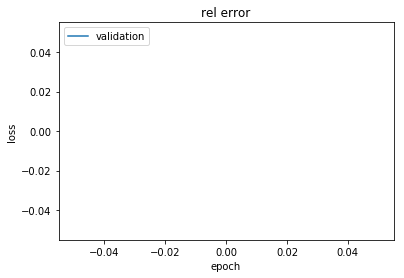

In [26]:
plt.plot(hist.history['val_relative_error'])
plt.title('rel error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

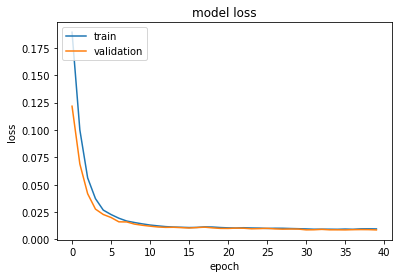

In [27]:
plot_trainingcurves(hist)

### Predicting

In [28]:
#test
predictions = model.predict(test_inputs, batch_size=10)
truth     = test_targets

predictions = np.reshape(predictions, (len(test_inputs),64,64,3))
truth       = np.reshape(truth, (len(test_targets),64,64,3))

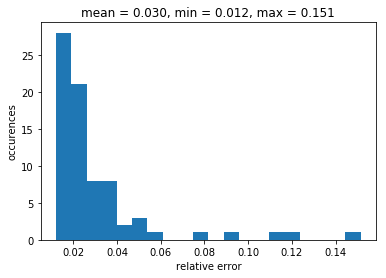

In [29]:
error_distribution(truth,predictions)

In [30]:
args = arg_getter(truth,predictions)

46


### Plot results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 75 + 1) instead
  import sys


64


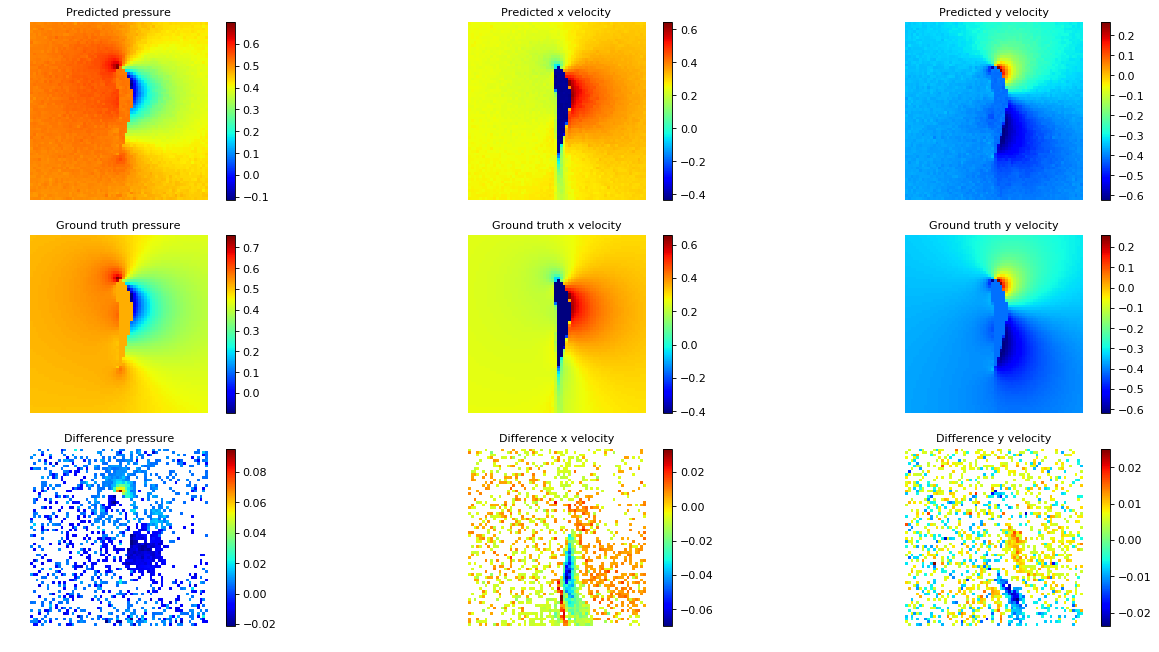

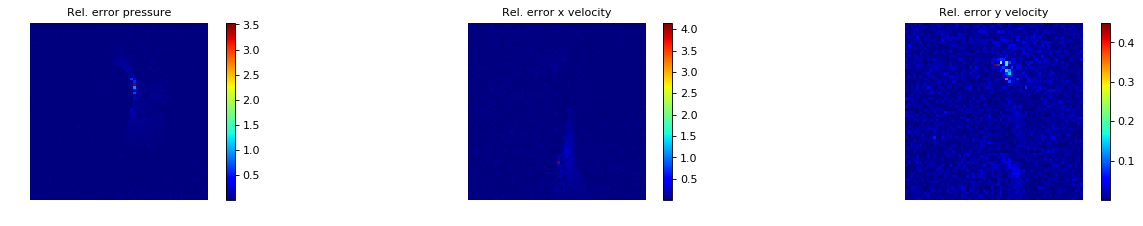

In [57]:
plotter(predictions,truth,index = args[1])

### Functions

In [32]:

#make figure
def plotter(x,y,index = -1):
    #x: predictions
    #y:ground truth
    length = len(x)
    random_sample = np.random.random_integers(0,length - 1)
    if index > -1:
        random_sample = index
    plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    print(random_sample)
# predicted data
    plt.subplot(331)
    plt.title('Predicted pressure', fontsize=10)
    plt.imshow(x[random_sample,:,:,0], cmap='jet')# vmin=-100,vmax=100, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(332)
    plt.title('Predicted x velocity', fontsize=10)
    plt.imshow(x[random_sample,:,:,1], cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(333)
    plt.title('Predicted y velocity', fontsize=10)
    plt.imshow(x[random_sample,:,:,2], cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
# ground truth data
    plt.subplot(334)
    plt.title('Ground truth pressure', fontsize=10)
    plt.imshow(y[random_sample,:,:,0],cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(335)
    plt.title('Ground truth x velocity', fontsize=10)
    plt.imshow(y[random_sample,:,:,1],cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(336)
    plt.title('Ground truth y velocity', fontsize=10)
    plt.imshow(y[random_sample,:,:,2],cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
# difference
    plt.subplot(337)
    p = y[random_sample,:,:,0] - x[random_sample,:,:,0]
    pmask = np.ma.masked_where(np.abs(p) <= 5e-3,p)
    plt.title('Difference pressure', fontsize=10)
    plt.imshow(pmask,cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(338)
    vx = y[random_sample,:,:,1] - x[random_sample,:,:,1]
    vxmask = np.ma.masked_where(np.abs(vx) <= 5e-3,vx)
    plt.title('Difference x velocity', fontsize=10)
    plt.imshow(vxmask,cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(339)
    vy = y[random_sample,:,:,2] - x[random_sample,:,:,2]
    vymask = np.ma.masked_where(np.abs(vy) <= 5e-3,vy)
    plt.title('Difference y velocity', fontsize=10)
    plt.imshow(vymask,cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
#relative error
    plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(331)
    plt.title('Rel. error pressure', fontsize=10)
    plt.imshow(np.abs(y[random_sample,:,:,0] - x[random_sample,:,:,0]) / np.abs(y[random_sample,:,:,0]),
               cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(332)
    plt.title('Rel. error x velocity', fontsize=10)
    plt.imshow(np.abs(y[random_sample,:,:,1] - x[random_sample,:,:,1]) / np.abs(y[random_sample,:,:,1]),
               cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(333)
    plt.title('Rel. error y velocity', fontsize=10)
    plt.imshow(np.abs(y[random_sample,:,:,2] - x[random_sample,:,:,2]) / np.abs(y[random_sample,:,:,2]),
               cmap='jet')
    plt.colorbar()
    plt.axis('off')

    plt.show()

In [33]:
#data preprocessing
#normalize values
# 2*(x + min)/max - 1
def preprocess_data(inputs,targets,norm = 1):
    '''
    norm == 1: normalize into [-1,1]
    norm == 2: normalize with dividing with maximum
    '''
    normalized_inputs = np.empty_like(inputs)
    normalized_targets = np.empty_like(targets)
    input_max = {}
    target_max = {}
    input_min = {}
    target_min = {}
    
    for ch in range(0,3):
        input_max[ch] = inputs[:,ch,:,:].max()
        input_min[ch] = inputs[:,ch,:,:].min()
        
        target_max[ch] = targets[:,ch,:,:].max()
        target_min[ch] = targets[:,ch,:,:].min() 
        
        #normalization 1
        if norm == 1: #to [-1,+1]
            normalized_inputs[:,ch,:,:] = 2*(inputs[:,ch,:,:] - input_min[ch])/(input_max[ch] - input_min[ch]) - 1
            normalized_targets[:,ch,:,:] = 2*(targets[:,ch,:,:] - target_min[ch])/(target_max[ch] - target_min[ch]) - 1
        
        #normalization 2
        if norm == 2: #just divide with maximum
            normalized_inputs[:,ch,:,:] = inputs[:,ch,:,:]/input_max[ch]
            normalized_targets[:,ch,:,:] = targets[:,ch,:,:]/target_max[ch]
    return normalized_inputs, normalized_targets

(-0.5, 63.5, 63.5, -0.5)

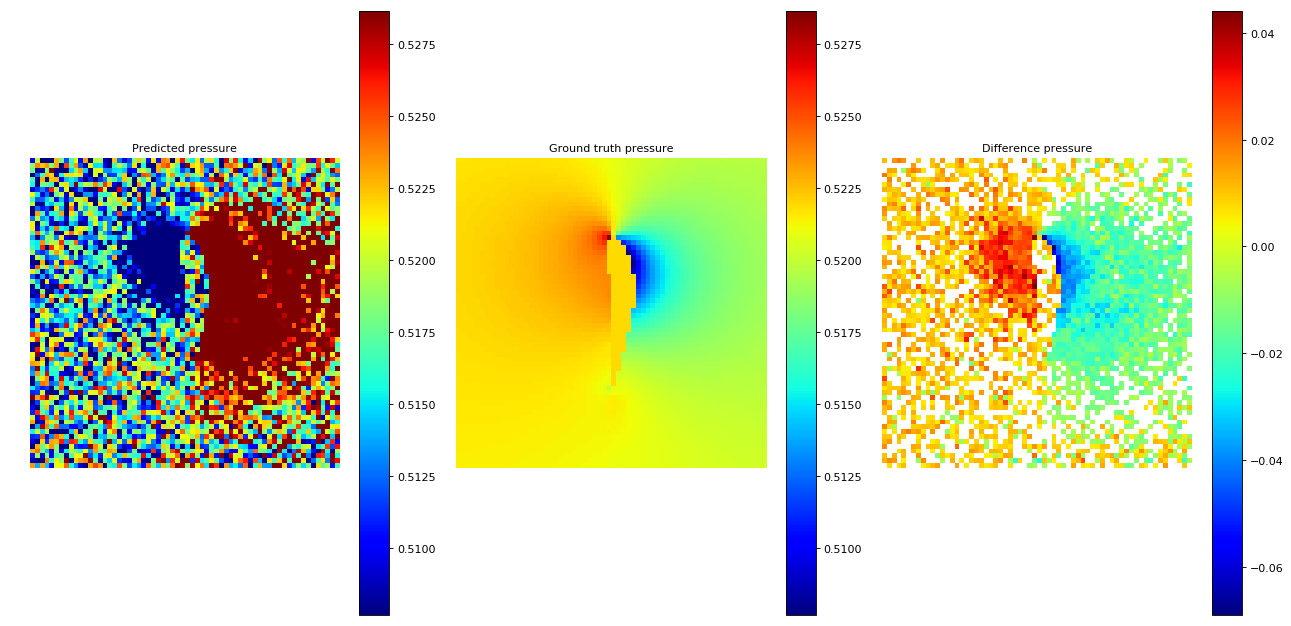

In [65]:
    arg = 0
    plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(131)
    plt.title('Predicted pressure', fontsize=10)
    plt.imshow(predictions[arg,:,:,0], cmap='jet',
               vmin=truth[arg,:,:,0].min(),
               vmax=truth[arg,:,:,0].max())
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(132)
    plt.title('Ground truth pressure', fontsize=10)
    plt.imshow(truth[arg,:,:,0],cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(133)
    p = truth[arg,:,:,0] - predictions[arg,:,:,0]
    pmask = np.ma.masked_where(np.abs(p) <= 5e-3,p)
    plt.title('Difference pressure', fontsize=10)
    plt.imshow(pmask,cmap='jet')
    plt.subplots_adjust(wspace = .1)
    plt.colorbar()
    plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

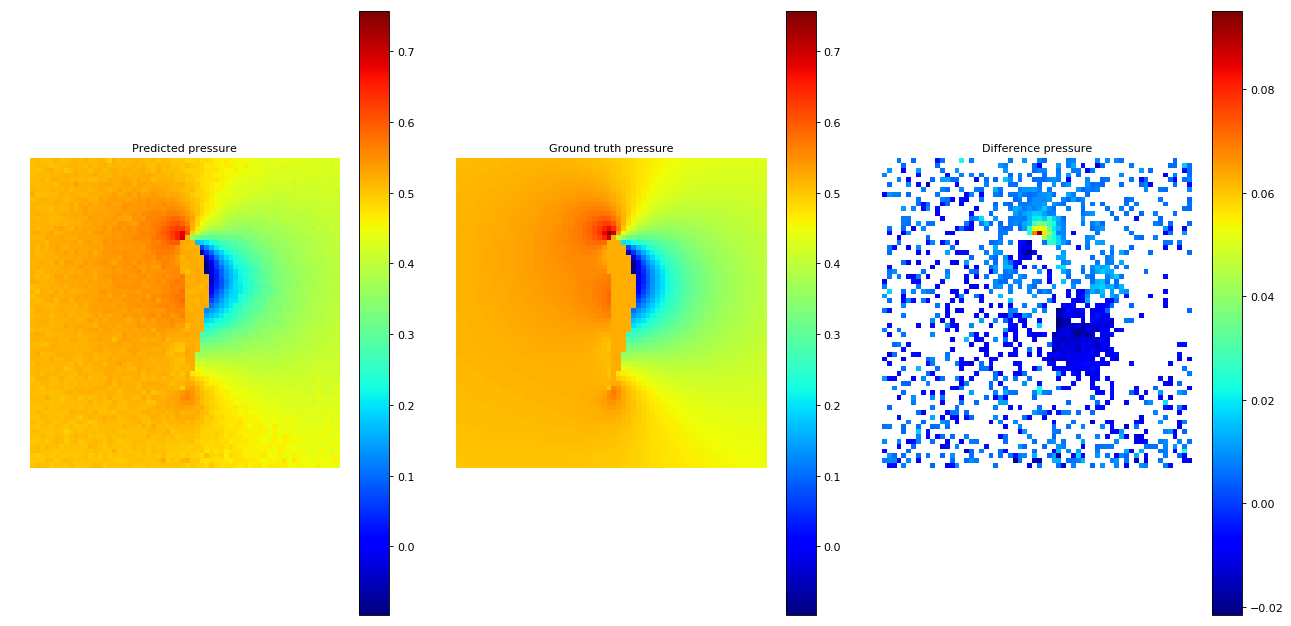

In [62]:
    arg = 64
    plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(131)
    plt.title('Predicted pressure', fontsize=10)
    plt.imshow(predictions[arg,:,:,0], cmap='jet', vmin=truth[arg,:,:,0].min(),vmax=truth[arg,:,:,0].max())
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(132)
    plt.title('Ground truth pressure', fontsize=10)
    plt.imshow(truth[arg,:,:,0],cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(133)
    p = truth[arg,:,:,0] - predictions[arg,:,:,0]
    pmask = np.ma.masked_where(np.abs(p) <= 5e-3,p)
    plt.title('Difference pressure', fontsize=10)
    plt.imshow(pmask,cmap='jet')
    plt.subplots_adjust(wspace = .1)
    plt.colorbar()
    plt.axis('off')